## Model Interpretability - Understanding SHAP on tabular dataset

### Abstarct

The motive of this project is to undertstand SHAP which one of the methods of Model Interpretability. We will focus on Python implementation of SHAP and various SHAP plots to understand the how the model interprets the data and makes decision. We will also understand local and global interpretability.  
 We will be using Heart disease UCI dataset from Kaggle to predict if a person has heart disease based on various feature values. the target values will be 0 & 1, 0 being patient does not have heart disease and 1 being patient has heart disease.

###Introduction to SHAP


A great way to increase the transparency of a model is by using SHAP values. **SHAP (SHapley Additive exPlanations)**, proposed by Lundberg and Lee (2016), is a united approach to explain the output of any machine learning model, by measuring the features’ importance to the predictions. SHAP (SHapley Additive exPlanations) is a game-theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.  
The benefits of using SHAP are both at an global and at a local level, as follows:  

• At a global level, the collective SHAP values help to interpret and understand the model. They show how much each predictor contributes, either positively or negatively, to the target variable. It allows for very intuitive interpretation of the model structure and is generalisable across a number of different modelling methodologies.  

• At a local level, each observation gets its own set of SHAP values (one for each predictor). This greatly increases transparency, by showing contributions to predictions on a case by case basis, which traditional variable importance algorithms are not able to do. Having the ability to explain each granular forecast opens the door to use of ML algorithms in credit decisioning, where Bank’s are required to explain why given credit decision was taken. In addition, local interpretability can aid in segmentation and outlier detection.

To give a better picture of how SHAP can be used and its benefits, we have developed two models; RandomForestRegression, and a recent ML predictive algorithm XGBoost (Boosting Ensemble of trees). We used SHAP values to interpret both models side-by-side and show how this approach works. 

###Dataset:  


This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to this date. 
The "target" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) and 1.  

age  
sex  
cp - chest pain type (4 values)  
trestbps - resting blood pressure  
chol - serum cholestoral in mg/dl  
fbs - fasting blood sugar > 120 mg/dl  
restecg - resting electrocardiographic results (values 0,1,2)  
thalach - maximum heart rate achieved  
exeng - exercise induced angina  
oldpeak - ST depression induced by exercise relative to rest  
slope - the slope of the peak exercise ST segment  
ca - number of major vessels (0-3) colored by flourosopy  
thal -  3 = normal; 6 = fixed defect; 7 = reversable defect      


Kaggle dataset: https://www.kaggle.com/ronitf/heart-disease-uci


### Implementation on two model

In [1]:
#Installing SHAP
!pip install shap

In [2]:
import pandas as pd #for manipulating data
import numpy as np #for manipulating data
import sklearn #for building models
import xgboost as xgb #for building models
import sklearn.ensemble #for building models
from sklearn.model_selection import train_test_split #for creating a hold-out sample
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import time #some of the routines take a while so we monitor the time
import os #needed to use Environment Variables in Domino
import matplotlib.pyplot as plt #for custom graphs at the end
import seaborn as sns #for custom graphs at the end

In [3]:
import pandas as pd
from pandas import DataFrame
url = 'https://raw.githubusercontent.com/Srushti104/Model-Interpretability-SHAP/main/Dataset/heart.csv'
df = pd.read_csv(url)

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [6]:
df[["age","trestbps","chol","thalach","oldpeak"]].describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [7]:
#checking for null values
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [8]:
#Splitting Independent and dependent variable
X=df.drop("target",axis=1)
y=df["target"]

In [9]:
uniques = {col: X[col].unique().tolist() for col in X.columns}

In [10]:
#Finding unique values less than 10
for k,v in uniques.items():
  if len(pd.Index(v)) <=10:
    X[k]= X[k].astype('category')

In [11]:
#list of categorical columns
cat_col = X.select_dtypes(include=['category']).columns
cat_col

Index(['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'], dtype='object')

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       303 non-null    int64   
 1   sex       303 non-null    category
 2   cp        303 non-null    category
 3   trestbps  303 non-null    int64   
 4   chol      303 non-null    int64   
 5   fbs       303 non-null    category
 6   restecg   303 non-null    category
 7   thalach   303 non-null    int64   
 8   exang     303 non-null    category
 9   oldpeak   303 non-null    float64 
 10  slope     303 non-null    category
 11  ca        303 non-null    category
 12  thal      303 non-null    category
dtypes: category(8), float64(1), int64(4)
memory usage: 15.4 KB


In [13]:
#list of numerical columns
num_col =['age','trestbps','chol','thalach','oldpeak']

In [14]:
# Splitting train and test dataset
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=123)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((242, 13), (242,), (61, 13), (61,))

### RandomForestClassifier Model

In [15]:
rfc_model = RandomForestClassifier(random_state=0).fit(X_train, y_train)

In [16]:
# fit the model with data
rfc_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [17]:
y_pred = rfc_model.predict(X_test)

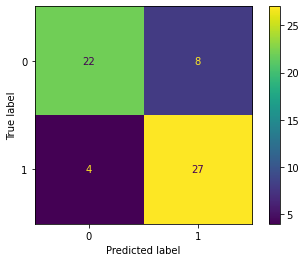

In [18]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(rfc_model, X_test, y_test)  
plt.show()

In [19]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8032786885245902


In [20]:
row_to_show = 11
data_for_prediction = X_train.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


rfc_model.predict_proba(data_for_prediction_array)

array([[0.06, 0.94]])

### Interpretation using SHAP

We are predicting whether a person  has heart disease based on  given values for each feature. Our target variable has value 0 and 1.   

Tree SHAP provides us with several different types of plots, each one highlighting a specific aspect of the model. The available plots are:

- Summary plot
- Force plot
- Dependence plot
- Decision plot

In [23]:
import shap

###Force Plot - Local interpretability:  
  

Another great aspect of SHAP is that it determines a separate set of values for each observation in the dataset. This feature can have multiple usages:  
• It allows to explain why model output takes given value for each observation (in case of heart disease decisioning, each yes/no can be explained).  
• It can determine the observations where a certain variable or a set of variables are more/less predictive, and thus it aids in segmentation;  
• It can help in optimizing the model by removing outliers (observations where SHAP values are low for a big number/ all variables)   
• It can help with model exclusions, as missing features have no attributed impact to the model parameters.  
For a local view which makes it clearer which way each variable is ‘pushing’ the model output towards, the following plots can be used, selecting the row/observation we want to show:

In [24]:
#Lets try to interpret random row say 50
row_to_show = 50
data_for_prediction = X_test.iloc[row_to_show] 

In [25]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rfc_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [26]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

In blue, we have negative Shap values that show everything that pushes the prediction  value in the negative direction. While the Shap value in red represents everything that pushes it towards a positive direction. Note that this is only for observation number 50.

From the plot we can see:  

- The model output value: 0.21  
- The base value of 0.552: this is the value that would be predicted if we didn’t know any features for the current output (Y_test.mean())
- The impact of each feature on the output.  

In particular, we can see some red and blue arrows associated with each feature.
Each of this arrow shows:  

- how much the feature impacts the model: the bigger the arrow, the bigger the impact.  
- how the feature impacts the model: a red arrow increases the model output value while a blue arrow decreases the model output value.  

In [27]:
# Trying force plot on row 47.
data_for_prediction1 = X_test.iloc[47] 

In [28]:
# Calculate Shap values
shap_values = shap.TreeExplainer(rfc_model).shap_values(data_for_prediction1)

In [29]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction1)

We can see that thal =3 and cp=2 has huge contribution towards pushing the output towards positive. While ca=1 and exang= 0 has negative contribution.

If we want a global representation of the previous predictions, we can use a variant of the force plot:

In [30]:
shap.initjs()
def shap_plot(j, model,S):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value[j], shap_values_Model[j], S)
    return(p)
shap_plot(0, rfc_model, X_test)

Here we can see the predictions made before (one for each interaction) place vertically (rotated of 90°) and side by side.

###Summary Plot - Global interpretability:  


At a global level, the below graphs are summarizing the effects of all the explanatory variables on the model output, colour coded to show the direction of the impact (red means an increase, while blue shows a decrease), with SHAP value more far away from zero meaning a bigger impact. It is also visually easy to see which variables have the strongest relationship with the target variable. In this way, SHAP can also be used as a tool for variable selection.


This can give us global information on the interpretability of the model.  
As we can see from the picture below, the plot represents:

- the most important feature of the model on the y-axis in a descending order (at the top - the most important one).  
- the SHAP value on the x-axis.  
- the feature value with colors. A high value is represented with red, while a low value with blue.  
Also here each point represent a prediction result.  

In [31]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rfc_model)

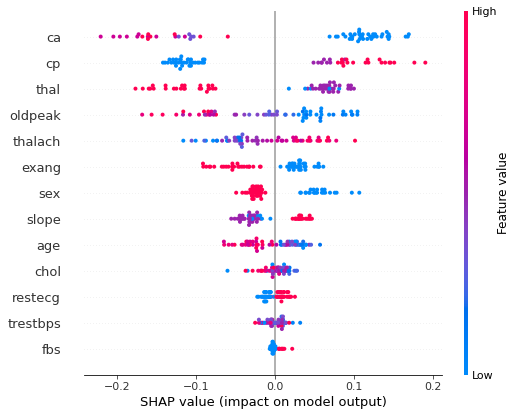

In [32]:
# Calculate Shap values and Make plot.
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test,show=False)

From above graph we can interpret cp has highest importance with lower value of cp has high impact on target variable.

We get the above plot by putting everything together under one roof. This shows the Shap values on the x-axis. Here, all the values on the left represent the observations that shift the predicted value in the negative direction while the points on the right contribute to shifting the prediction in a positive direction. All the features are on the left y-axis.

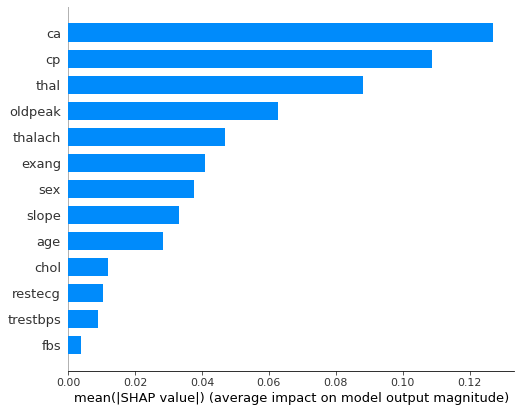

In [33]:
shap.summary_plot(shap_values[1], X_test,show=False,plot_type="bar")

This is very basic summary plot or also known as feature importance plot where we can interpret which feature has highest impact.

### Dependence Plot

Another plot useful for the local interpretability is the dependence plot.
This plot compares a chosen feature with another one and shows if these two features have an interaction effect.

As an example, I reported here the dependence plot between age and cp for a model 

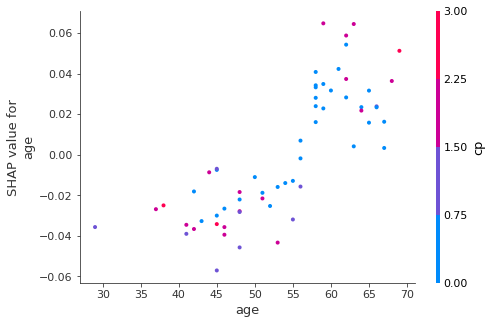

In [34]:
import matplotlib.pylab as pl

# create a dependence plot to show the effect of a single feature across the whole dataset
shap_values = explainer.shap_values(X_test)
# make plot.
shap.dependence_plot('age', shap_values[0], X_test,show=False)


Here each point corresponds to a prediction. In the x-axis we have the Age while in the y-axis we have the predicted SHAP value (how much knowing that feature’s value changes the output of the model for that sample’s prediction).  
The color represent "cp" so we can see for specific age and cp value how does it impact.

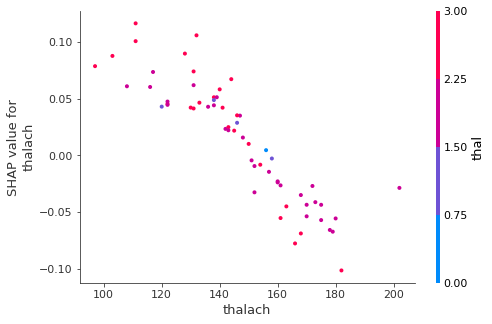

In [35]:
shap.dependence_plot('thalach', shap_values[0], X_test,show=False)

### Decision Plot

This plot shows how the prediction changes during the decision process. In the y-axis we have the features ordered by importance as for the summary plot. In the x-axis we have the output of the model.

Moving from the bottom of the plot to the top, SHAP values for each feature are added to the model’s base value. This shows how each feature contributes to the overall prediction  

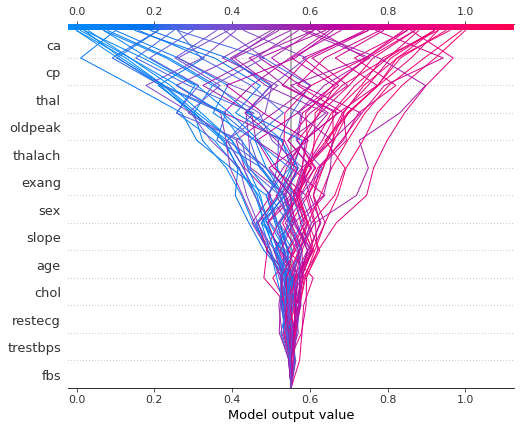

In [36]:
shap.decision_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

### SHAP Implementation on XGBClassifier Model

In [37]:
#converting cat to bool
X[cat_col]= X[cat_col].astype('bool')

In [38]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    bool   
 2   cp        303 non-null    bool   
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    bool   
 6   restecg   303 non-null    bool   
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    bool   
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    bool   
 11  ca        303 non-null    bool   
 12  thal      303 non-null    bool   
dtypes: bool(8), float64(1), int64(4)
memory usage: 14.3 KB


In [39]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=123)

In [40]:
import xgboost as xgb
from xgboost import XGBClassifier
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

In [41]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(n_estimators=100)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [42]:
y_pred = xgb_model.predict(X_test)

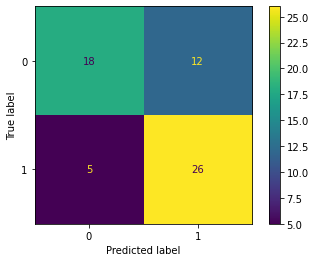

In [43]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(xgb_model, X_test, y_test)  
plt.show()

In [44]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7213114754098361


### Interpretation using SHAP

In [45]:
# Implemeting SHAP TreeExplainer on XGBoost
explainerXGB = shap.TreeExplainer(xgb_model)
shap_values_XGB_test = explainerXGB.shap_values(X_test)
shap_values_XGB_train = explainerXGB.shap_values(X_train)

In [46]:
df_shap_XGB_test = pd.DataFrame(shap_values_XGB_test, columns=X_test.columns.values)
df_shap_XGB_train = pd.DataFrame(shap_values_XGB_train, columns=X_train.columns.values)

### Force Plot

We will randomly pick a persons record. Here we have selected row 25.

In [47]:
shap.initjs()
j=25
shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test[j], X_test.iloc[[j]])

We can see the base value here is 0.27 and out predicted value is 0.40. ca=0 and cp=0 has same impact magnitude but in opposite direction. One contributing to positive and other towards negative.

In [48]:
shap.initjs()
shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test, X_test)

### Summary Plot

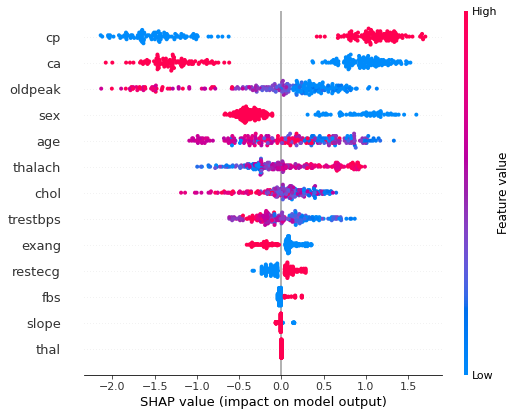

In [49]:
shap.summary_plot(shap_values_XGB_train, X_train)

Here we can say, lower the value of "cp" it has higher positive impact and vice versa for feature "ca". There is no clear prediction with feature "age"

### Dependence Plot

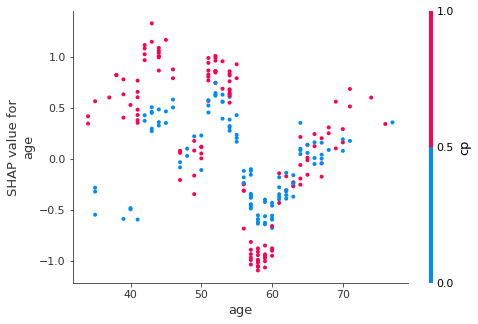

In [50]:
shp_plt = shap.dependence_plot("age", shap_values_XGB_train, X_train)

We can interpret form above graph that 55-60 age group lower SHAP value hence has low relevant impact .

### Decision Plot

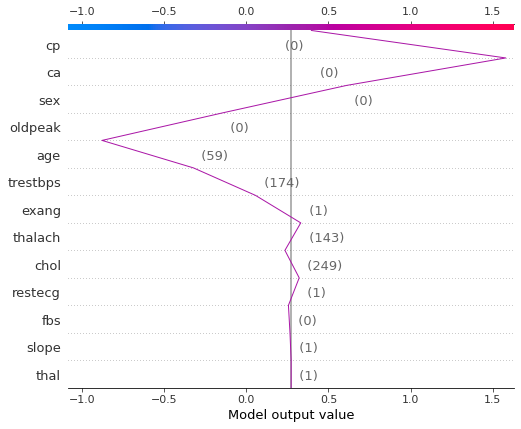

In [51]:
shap.decision_plot(explainerXGB.expected_value, shap_values_XGB_test[j], X_test.iloc[[j]])

Here the value of each features is reported in parenthesis.  
From the graph we can see that last 4 features have no impact while age,trestbps makes negative impact and ca = 0 sex=female, starts making positive impact.

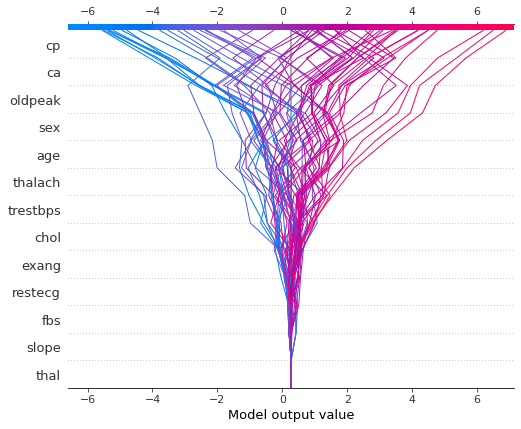

In [52]:
shap.initjs()
shap.decision_plot(explainerXGB.expected_value, shap_values_XGB_test, X_test)

Moving from the bottom of the plot to the top, SHAP values for each feature are added to the model’s base value. This shows how each feature contributes to the overall prediction. Each line represent single prediction.

### Conclusion  
SHAP is a very useful tool in addressing one of the most stringent issues with ML models:
interpretability/explainability.    

In summary, Shapley values calculate the importance of a feature by comparing what a model predicts with and without the feature. However, since the order in which a model sees features can affect its predictions, this is done in every possible order, so that the features are fairly compared.    

It can be used both in the development and the validation stage. The development of a ML model can be improved by SHAP through outlier and missing value detection, segmentation, variable selection, and variable interaction analysis. In the validation/model governance stage, SHAP offers a clear way of explaining the components interactions and effects, it can aid in determining the cause of a drop in performance, and in enabling the validator to propose changes that might redress the issues. 


### Reference  
https://github.com/slundberg/shap
https://shap.readthedocs.io/en/latest/generated/shap.TreeExplainer.html
https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
https://medium.com/abhi-kar/shap-up-51a059fbd9a9
https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

### Citation  
https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values

### License  
<div class="alert alert-block alert-info">
    <b>Copyright</b> 2020 Srushti Dhamangaonkar<br>
    <br>Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:<br>
    <br>The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.<br>
    <br>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
    <br><br>
    
<div class="text-center">
    <a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/3.0/us/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/">Creative Commons Attribution 3.0 United States License</a>.<br>
</div></div>